<h1 align="center">Тестовое задание </h1> 

  <a id='link_0'></a>

## Содержание
 <a href='#link_1'>1. Постановка задачи.</a>
 
 <a href='#link_2'>2. Подготовка инфраструктуры.</a>
 
 <a href='#link_3'>3. Изучение формата данных MS-COCO.</a>
 
 <a href='#link_4'>4. Создание модели Mask_RCNN на предобученных весах MS-COCO.</a>
 
 <a href='#link_5'>5. Дообучение модели на синтезированных данных в формате MS-COCO.</a>
 
 <a href='#link_6'>6. Дообучение модели на датасетах в формате MS-COCO.</a>
 
 <a href='#link_7'>7. Оптимизация исполнения модели.</a>
 
 <a href='#link_8'>8. Валидация модели по качеству во время исполнения.</a>

<a id='link_1'></a>

## 1. Постановка задачи

1.1. Построить модель детекции/multilabel-классификации на MS-COCO.

1.2. Модель должна быть дообучаема на новых данных и датасетах в формате и аннотации COCO.

1.3. Оптимизировать исполнение модели какими-либо средствами (на выбор).

1.4. Предложить для выбранной задачи метод валидации модели по качеству во время исполнения.

<a id='link_2'></a>

## 2. Подготовка инфраструктуры

2.1. Установить Docker.

2.2. Скачать необходимый образ (зависит от версии CPU):
    * docker pull floydhub/tensorflow:1.9.0-py3_aws.35
2.3. Запустить контейнер:
    * docker run -it -p 9999:9999 floydhub/tensorflow:1.9.0-py3_aws.35 /bin/bash
2.4. Настроить контейнер:
    * apt update && apt upgrade -y
    * apt install curl wget git mc htop -y
    * cd /tmp
    * git clone https://github.com/matterport/Mask_RCNN.git
    * cd Mask_RCNN
    * pip3 install --upgrade pip
    * which jupyter
    * pip3 install -r requirements.txt 
    * pip3 install --upgrade Cython pycocotools
    * python -m pip uninstall keras --yes
    * python -m pip uninstall tensorflow --yes
    * pip install tensorflow==1.5.0
    * pip install keras==2.0.8
    * python3 setup.py install
2.5. Проверить правильность версий:
    * python3 -c "import tensorflow as tf; print(tf.__version__);import keras; print(keras.__version__)"
2.6. Сохранить изменения контейнера в образ:
    * docker ps
    * docker stop db55669ce797
    * docker commit db55669ce797 floydhub/tensorflow:1.9.0-py3_aws.35_4
    * docker rm db55669ce797
2.7. Запустить контейнер с новыми настройками:
    * docker run -it -v /Volumes/Data/docker/:/mounted -p 9999:9999 -p 6006:6006 floydhub/tensorflow:1.9.0-py3_aws.35_4 /bin/bash -c "/usr/local/bin/jupyter notebook --notebook-dir=/tmp --ip='*' --port=9999 --no-browser --allow-root"
2.8. Подключиться к ноутбуку:
    * http://localhost:9999/?token=1437be79b3001ec63ff6e6bdf66b88a534e587456501b335
2.9. Подключиться к контейнеру:
    * docker ps
    * docker exec -it 35b81eab0302 bash
2.A. Проверить работоспособность:
    * python3 -c "import tensorflow as tf; print(tf.__version__);import keras; print(keras.__version__)"
2.B. Запустить tensorboard:
    * tensorboard --logdir /tmp/logs/

<div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

<a id='link_3'></a>

## 3. Изучение формата данных MS-COCO

In [ ]:
#https://russianblogs.com/article/82091650119/

### 3.1. Описание формата набора данных COCO

Полное название COCO - Common Objects in COntext, это набор данных, предоставленный командой Microsoft, который можно использовать для распознавания изображений. Изображения в наборе данных MS COCO разделены на наборы для обучения, проверки и тестирования. COCO собирает изображения путем поиска 80 категорий объектов и различных типов сцен на Flickr с помощью Amazon Mechanical Turk (AMT).

Набор данных COCO имеет 3 типа описания (аннотаций):
* экземпляры объектов
* ключевые точки объектов 
* подписи к изображениям

Для хранения данных используестся формат JSON. 

<b>Пример:</b>

In [ ]:
{"license": 1,
 "file_name": "000000479400.jpg",
 "coco_url": "http://images.cocodataset.org/train2017/000000479400.jpg",
 "height": 640,
 "width": 434,
 "date_captured": "2013-11-15 02:12:20",
 "flickr_url": "http://farm9.staticflickr.com/8516/8472642889_827b8258d1_z.jpg",
 "id": 479400}

### 3.2. Рассмотрим формат COCO на примерах:

In [2]:
%matplotlib inline
from datetime import datetime
from __future__ import print_function
from pycocotools.coco import COCO
import urllib.request
import shutil
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os, sys, zipfile
import random
import math
import skimage.io
import matplotlib
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import re
import time
import cv2

In [ ]:
# Создадими папку для хранения изображений и аннотаций:

COCO_DIR = os.path.join('/mounted', "cocodataset")
if not os.path.exists(COCO_DIR):
    os.makedirs(COCO_DIR)

# Скачаем набор данных для обучения, валидации и описаний:

!wget -O '/mounted/cocodataset/val2017.zip' http://images.cocodataset.org/zips/val2017.zip
!wget -O '/mounted/cocodataset/annotations_trainval2017.zip' http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget -O '/mounted/cocodataset/train2017.zip' http://images.cocodataset.org/zips/train2017.zip

# Распакуем фалы в папки:

for file in ["val2017.zip", "annotations_trainval2017.zip", "train2017.zip"]:
    with zipfile.ZipFile(os.path.join(COCO_DIR, file),"r") as zip_ref:
        zip_ref.extractall(COCO_DIR)   

# Удалим архивы:

for file in ["val2017.zip", "annotations_trainval2017.zip", "train2017.zip"]:
    if os.path.isfile(os.path.join(COCO_DIR, file)):
        os.remove(os.path.join(COCO_DIR, file))

--2021-07-17 17:16:44--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.243.36
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.243.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/mounted/cocodataset/val2017.zip’

ataset/val2017.zip   49%[========>           ] 385.28M  4.63MB/s    eta 69s    

In [ ]:
# Ссылка на файл с аннотациями:

dataDir='/mounted/cocodataset/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [ ]:
coco=COCO(annFile)

In [ ]:
# Существуют категории и подкатегории.
# например: овцы (основная категория) делятся на коз, овец, тибетских антилоп (подкатегория) и т. Д.

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

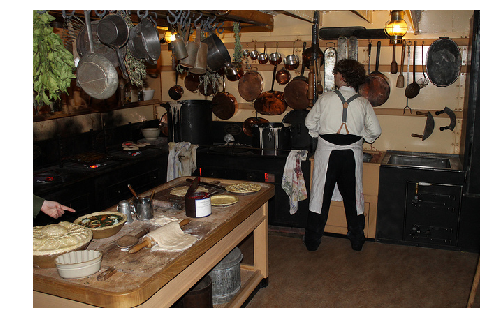

In [29]:
# Посмотрим на произвольное озображение:

imgIds = coco.getImgIds()
img = coco.loadImgs(imgIds[0])[0]
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show() 

In [30]:
# Где:

img

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [31]:
# Загрузим и посмотрим какие аннтотации для данного изображения:

catIds=[]
for ann in coco.dataset['annotations']:
    if ann['image_id']==imgIds[0]:
        catIds.append(ann['category_id'])

In [70]:
nms=[cat['name'] for cat in cats if cat['id'] in catIds]
print('Примеры категорий на данном изображении: \n{}\n'.format(' '.join(nms)))

Примеры категорий на данном изображении: 
person bottle cup knife spoon bowl broccoli carrot dining table oven sink



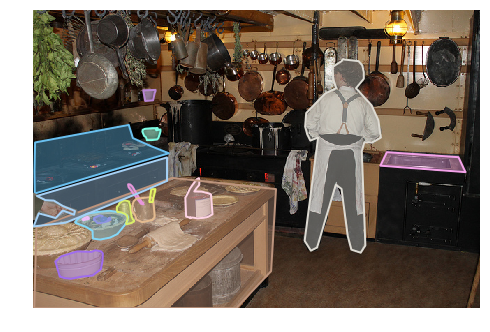

In [63]:
# Для каждой категории загрузим и посмотрим маску:

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
plt.imshow(I); plt.axis('off')
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

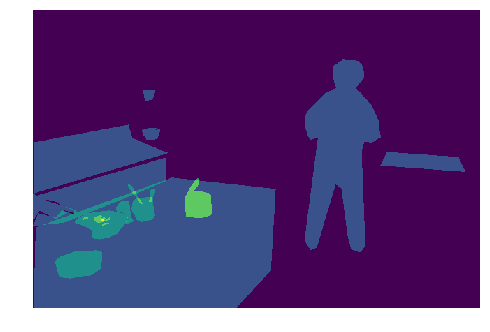

In [68]:
# Вывод только масок изображения:

mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])
plt.axis('off')
plt.imshow(mask)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


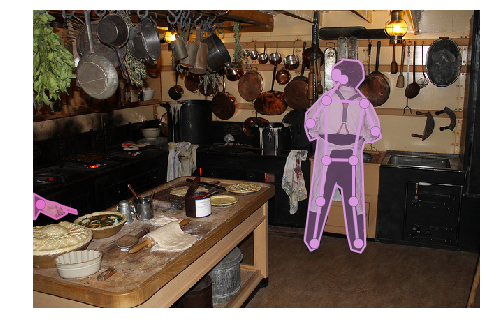

In [45]:
# Загрузим и посмотрим ключевые точки:

annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)


In [61]:
# Загрузим и посмотрим текстовое описание изображения

annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
print('\n'+'Текстовое описание изображения:'+'\n')
coco_caps.showAnns(anns)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!

Текстовое описание изображения:

A man is in a kitchen making pizzas.
Man in apron standing on front of oven with pans and bakeware
A baker is working in the kitchen rolling dough.
A person standing by a stove in a kitchen.
A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.


<a id='link_4'></a><div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

## 4. Создание модели Mask_RCNN на предобученных весах MS-COCO

In [4]:
#https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb
#пример использования модели, предварительно обученной в MS COCO, 
#для сегментации объектов в ваших собственных изображениях. 
#Он включает код для запуска обнаружения объектов и сегментации экземпляров на произвольных изображениях.

In [3]:
# Загрузим модель Mask_RCNN, библиотеки и предобученные веса для модели в формате MS-COCO

os.chdir('/tmp/Mask_RCNN')
ROOT_DIR = '/tmp/Mask_RCNN'

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
import mrcnn.model as modellib

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [124]:
# Определим и посмотрим конфигурацию:

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [77]:
# Создадим модель в режиме "Вывода":

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [78]:
# Загрузим в модель предобученные веса формата MS-COCO:

model.load_weights(COCO_MODEL_PATH, by_name=True)

In [82]:
# Текщие имена классов в предобученной модели:

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [114]:
# Загрузим случайное изображение с локального хранилища:

file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

In [121]:
# Запустим поиск объектов на изображении:

#%%time
start = datetime.now()
results = model.detect([image], verbose=1)
stop = datetime.now()
print("\n"+"{} секунд(ы)".format((stop - start).total_seconds()))

Processing 1 images
image                    shape: (438, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

5.376358 секунд(ы)


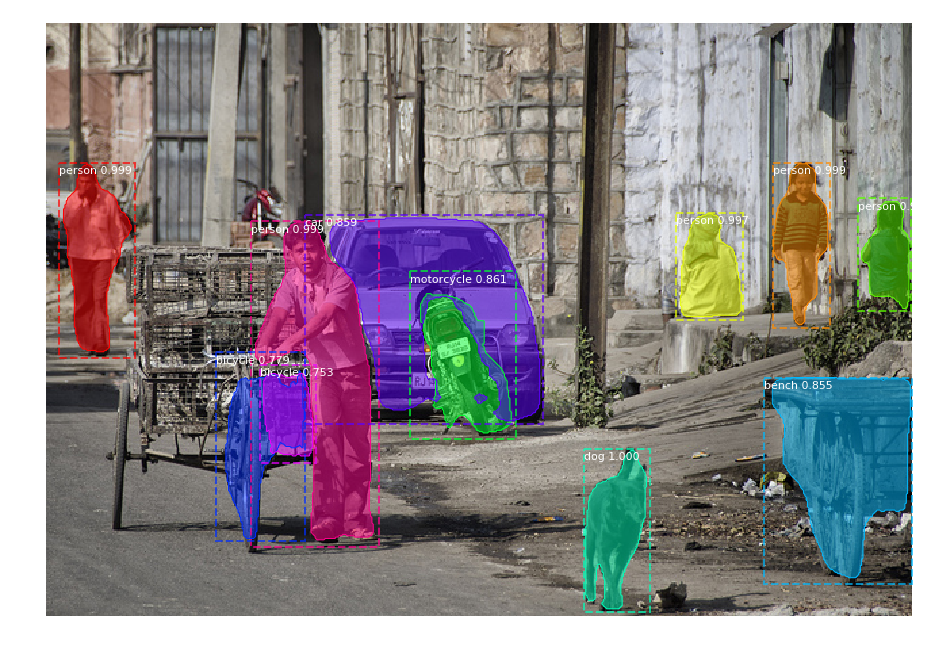

In [122]:
# Посмотрим на детекцию объектов моделью на случайном изображении:

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

<a id='link_5'></a><div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

## 5. Дообучение модели на синтезированных данных в формате MS-COCO.

### 5.1. Создадим генератор изображений для тестирования обучения на новых данных

In [136]:
# Класс конфигурации генератора:

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3 + 1  # background + 4 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [137]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [138]:
# К имеющемуся примеру создания датасета добавим еще одно тестовое изображение - крест (cross):

class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "cross")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        w = int(s/3)
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == 'cross':
            cv2.rectangle(image, (x-w, y-s), (x+w, y+s), color, -1)
            cv2.rectangle(image, (x-s, y-w), (x+s, y+w), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle", "cross"])
        #shape = "car"
        
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 5)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

### 5.2. Сгенерируем данные

In [129]:
# Сгенерируем данные для обучения:

dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Сгенерируем данные для валидации:

dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

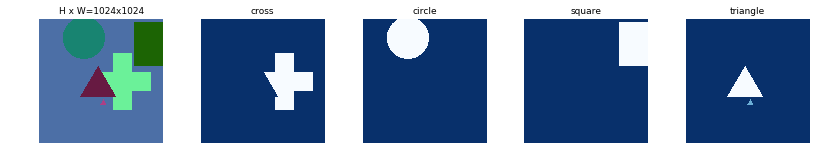

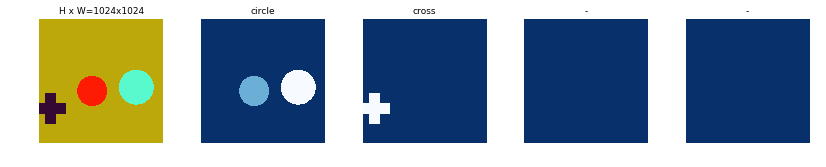

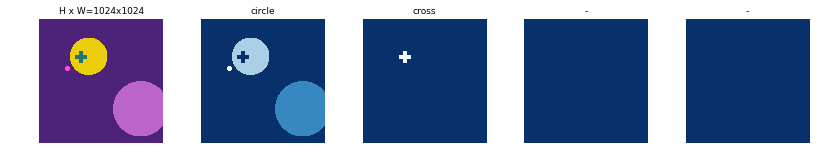

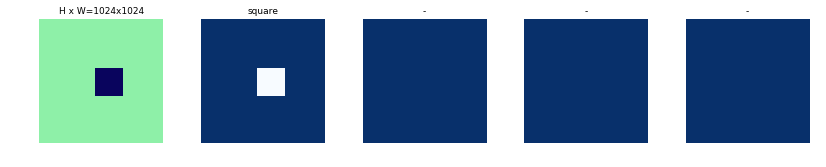

In [130]:
# Пример сгенерированных изображений и их масок:

image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

### 5.3. Создадим модель и загрузим предобученные веса

In [140]:
# Создадим модель в режиме "Обучения":

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [142]:
# Загрузим предобученные веса:

init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

### 5.4. Тренируем нужные слои модели

In [ ]:
# Тренируем только слои "heads". "Заморозим" все слои, кроме "heads" и будем их тренировать на наших данных.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

#100/100 [==============================] - 2151s - loss: 2.0447 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6671 - mrcnn_class_loss: 0.5347 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.3470 - val_loss: 1.0584 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.4505 - val_mrcnn_class_loss: 0.2095 - val_mrcnn_bbox_loss: 0.2237 - val_mrcnn_mask_loss: 0.1583

In [ ]:
# Дообучим все остальные слои:

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

#100/100 [==============================] - 1951s - loss: 0.9620 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4234 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.1633 - val_loss: 1.0143 - val_rpn_class_loss: 0.0152 - val_rpn_bbox_loss: 0.4543 - val_mrcnn_class_loss: 0.1985 - val_mrcnn_bbox_loss: 0.1654 - val_mrcnn_mask_loss: 0.1809

In [209]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Пересоздадим модель и загрузим веса из последней удачной конфигурации:

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /tmp/Mask_RCNN/logs/shapes20210716T1053/mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


### 5.5. Проверим результат на тестовом изображении

original_image           shape: (128, 128, 3)         min:   16.00000  max:  190.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (2, 4)                min:   30.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


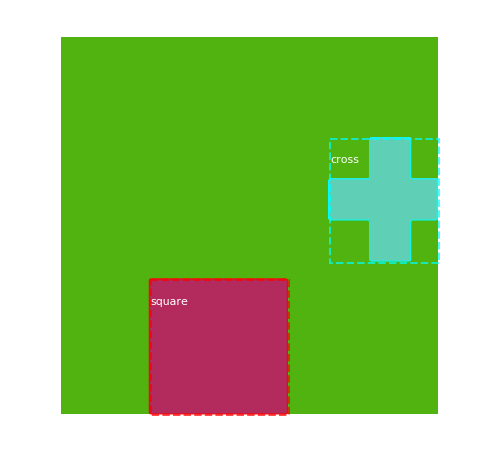

In [202]:
# Сгенерируем тестовое изображение:

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   16.00000  max:  190.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -87.90000  max:   80.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32

0.984877 секунд(ы)


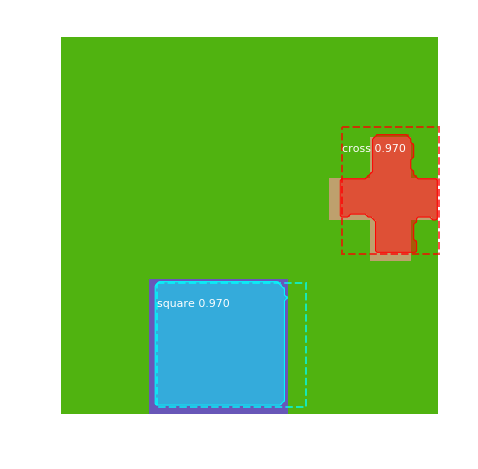

In [203]:
# Произведем детекцию объектов и посмотрим результат:

start = datetime.now()

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

stop = datetime.now()
print("\n"+"{} секунд(ы)".format((stop - start).total_seconds()))

### 5.6. Посмотрим на качество работы модели

In [205]:
# Посчитаем метрику mAP:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6155555588503678


<a id='link_6'></a><div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

# 6. Дообучение модели на датасетах в формате MS-COCO.

### 6.1 Подготовим датасет для обучения

In [ ]:
# В качестве нового датасета для обучения скачаю рисунки воздушных шаров

# Создадими папку для хранения изображений и аннотаций:

COCO_DIR = os.path.join('/mounted', "cocodataset")
if not os.path.exists(COCO_DIR):
    os.makedirs(COCO_DIR)

# Скачаем набор данных для обучения, валидации и описаний:

!wget -O '/mounted/cocodataset/balloon_dataset.zip' https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip

# Распакуем фалы в папки:

with zipfile.ZipFile(os.path.join(COCO_DIR, 'balloon_dataset.zip'),"r") as zip_ref:
    zip_ref.extractall(COCO_DIR)   

# Удалим архивы:

if os.path.isfile(os.path.join(COCO_DIR, 'balloon_dataset.zip')):
    os.remove(os.path.join(COCO_DIR, 'balloon_dataset.zip'))

In [14]:
from samples.balloon import balloon
BALLON_WEIGHTS_PATH = "/mounted/cocodataset/mask_rcnn_balloon.h5"
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "/mounted/cocodataset/balloon")

In [5]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### 6.2. Загрузим данные для валидации

In [8]:
# Load validation dataset

TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

dataset_val = balloon.BalloonDataset()
dataset_val.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 13
Classes: ['BG', 'balloon']


### 6.3. Загрузим данные для обучения

In [9]:
# Load train dataset
dataset_train = balloon.BalloonDataset()
dataset_train.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset_train.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Images: 61
Classes: ['BG', 'balloon']


In [6]:
# Загрузим модель Mask_RCNN, библиотеки и предобученные веса для модели в формате MS-COCO

os.chdir('/tmp/Mask_RCNN')
ROOT_DIR = '/tmp/Mask_RCNN'

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
import mrcnn.model as modellib

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [11]:
# Определим и посмотрим конфигурацию:

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [12]:
# Класс конфигурации генератора:

class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = BalloonConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### 6.4. Создадим модель

In [13]:
# Создадим модель в режиме "Обучения":

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
# Загрузим предобученные веса:

init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

### 6.5. Тренируем нужные слои модели

In [ ]:
# Тренируем только слои "heads". "Заморозим" все слои, кроме "heads" и будем их тренировать на наших данных.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

#100/100 [==============================] - 2151s - loss: 2.0447 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6671 - mrcnn_class_loss: 0.5347 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.3470 - val_loss: 1.0584 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.4505 - val_mrcnn_class_loss: 0.2095 - val_mrcnn_bbox_loss: 0.2237 - val_mrcnn_mask_loss: 0.1583

In [ ]:
# Дообучим все остальные слои:

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1, 
            layers="all")

#100/100 [==============================] - 1951s - loss: 0.9620 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4234 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.1633 - val_loss: 1.0143 - val_rpn_class_loss: 0.0152 - val_rpn_bbox_loss: 0.4543 - val_mrcnn_class_loss: 0.1985 - val_mrcnn_bbox_loss: 0.1654 - val_mrcnn_mask_loss: 0.1809

In [209]:
# Пересоздадим модель для проверки:

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Пересоздадим модель и загрузим веса из последней удачной конфигурации
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /tmp/Mask_RCNN/logs/shapes20210716T1053/mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


### 6.6. Проверим результат на тестовом изображении

In [7]:
"""
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from datetime import datetime
# Root directory of the project
os.chdir('/tmp/Mask_RCNN')
ROOT_DIR = '/tmp/Mask_RCNN'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon
%matplotlib inline 

MODEL_DIR = os.path.join('/tmp/Mask_RCNN/logs')
sys.path.append(MODEL_DIR)

BALLON_WEIGHTS_PATH = "/mounted/cocodataset/mask_rcnn_balloon.h5"  # TODO: update this path
BALLOON_DIR = os.path.join(ROOT_DIR, "/mounted/cocodataset/balloon")
config = balloon.BalloonConfig()

class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()

# Загрузим модель Mask_RCNN, библиотеки и предобученные веса для модели в формате MS-COCO
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(BALLON_WEIGHTS_PATH, by_name=True)
"""

In [10]:
# Возьмем одно из изображений:

dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

dataset.prepare()
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

In [11]:
# Запустим поиск объектов на изображении:

#%%time
start = datetime.now()
results = model.detect([image], verbose=1)
stop = datetime.now()
print("\n"+"{} секунд(ы)".format((stop - start).total_seconds()))

Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

48.167739 секунд(ы)


In [13]:
class_names = ['BG', 'balloon']

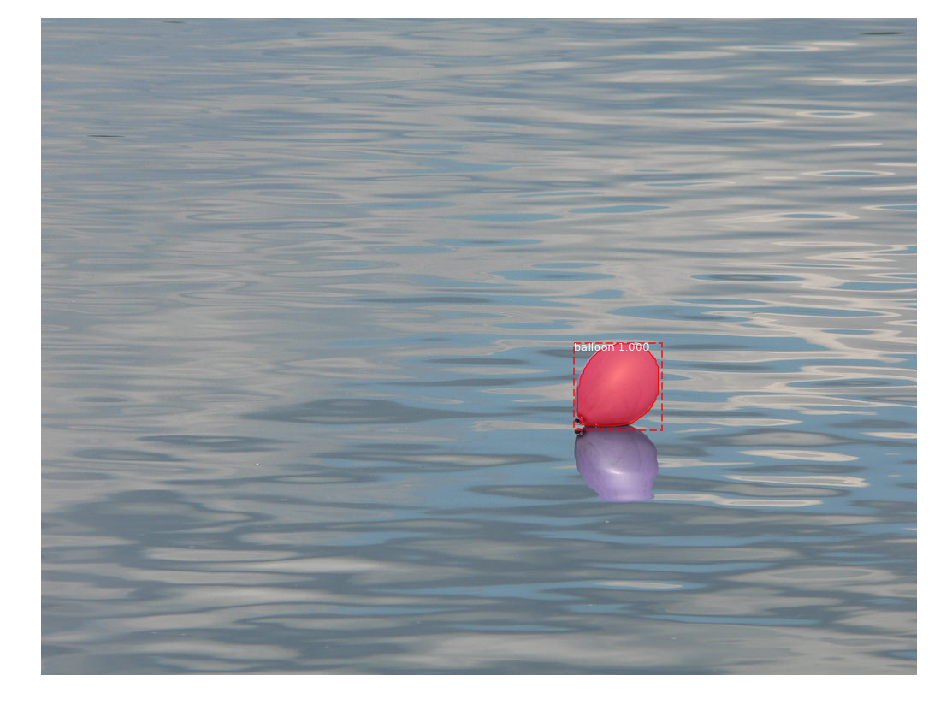

In [14]:
# Посмотрим на детекцию объектов моделью на случайном изображении:

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

 <a id='link_7'></a><div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

# 7. Оптимизация исполнения модели.

### 7.1. При обучении модели использовать различные комбинации слоев, которые будем тренировать
 
 7.2. Варьировать параметрами модели при обучении, например: Learning_Rate, количество эпох
 
 7.3. Использовать аугментацию (пример в пункте 8.3.)
 
 7.4. Использовать специфичную для tf кросс-валидацию
 
 7.5. Использовать validation_split в model.fit
 

In [2]:
# https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

<a id='link_8'></a><div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

## 8. Валидация модели по качеству во время исполнения

### 8.1. Использовать tensorboard

Для просмотра качества модели и различных параметров:
1. Запустить в консоли tensorboard:

    tensorboard --logdir /tmp/logs/
    
2. Подключиться по ссылке:

    http://127.0.0.1:6006/

In [8]:
# Пример вывода для результатов обучения модели выше

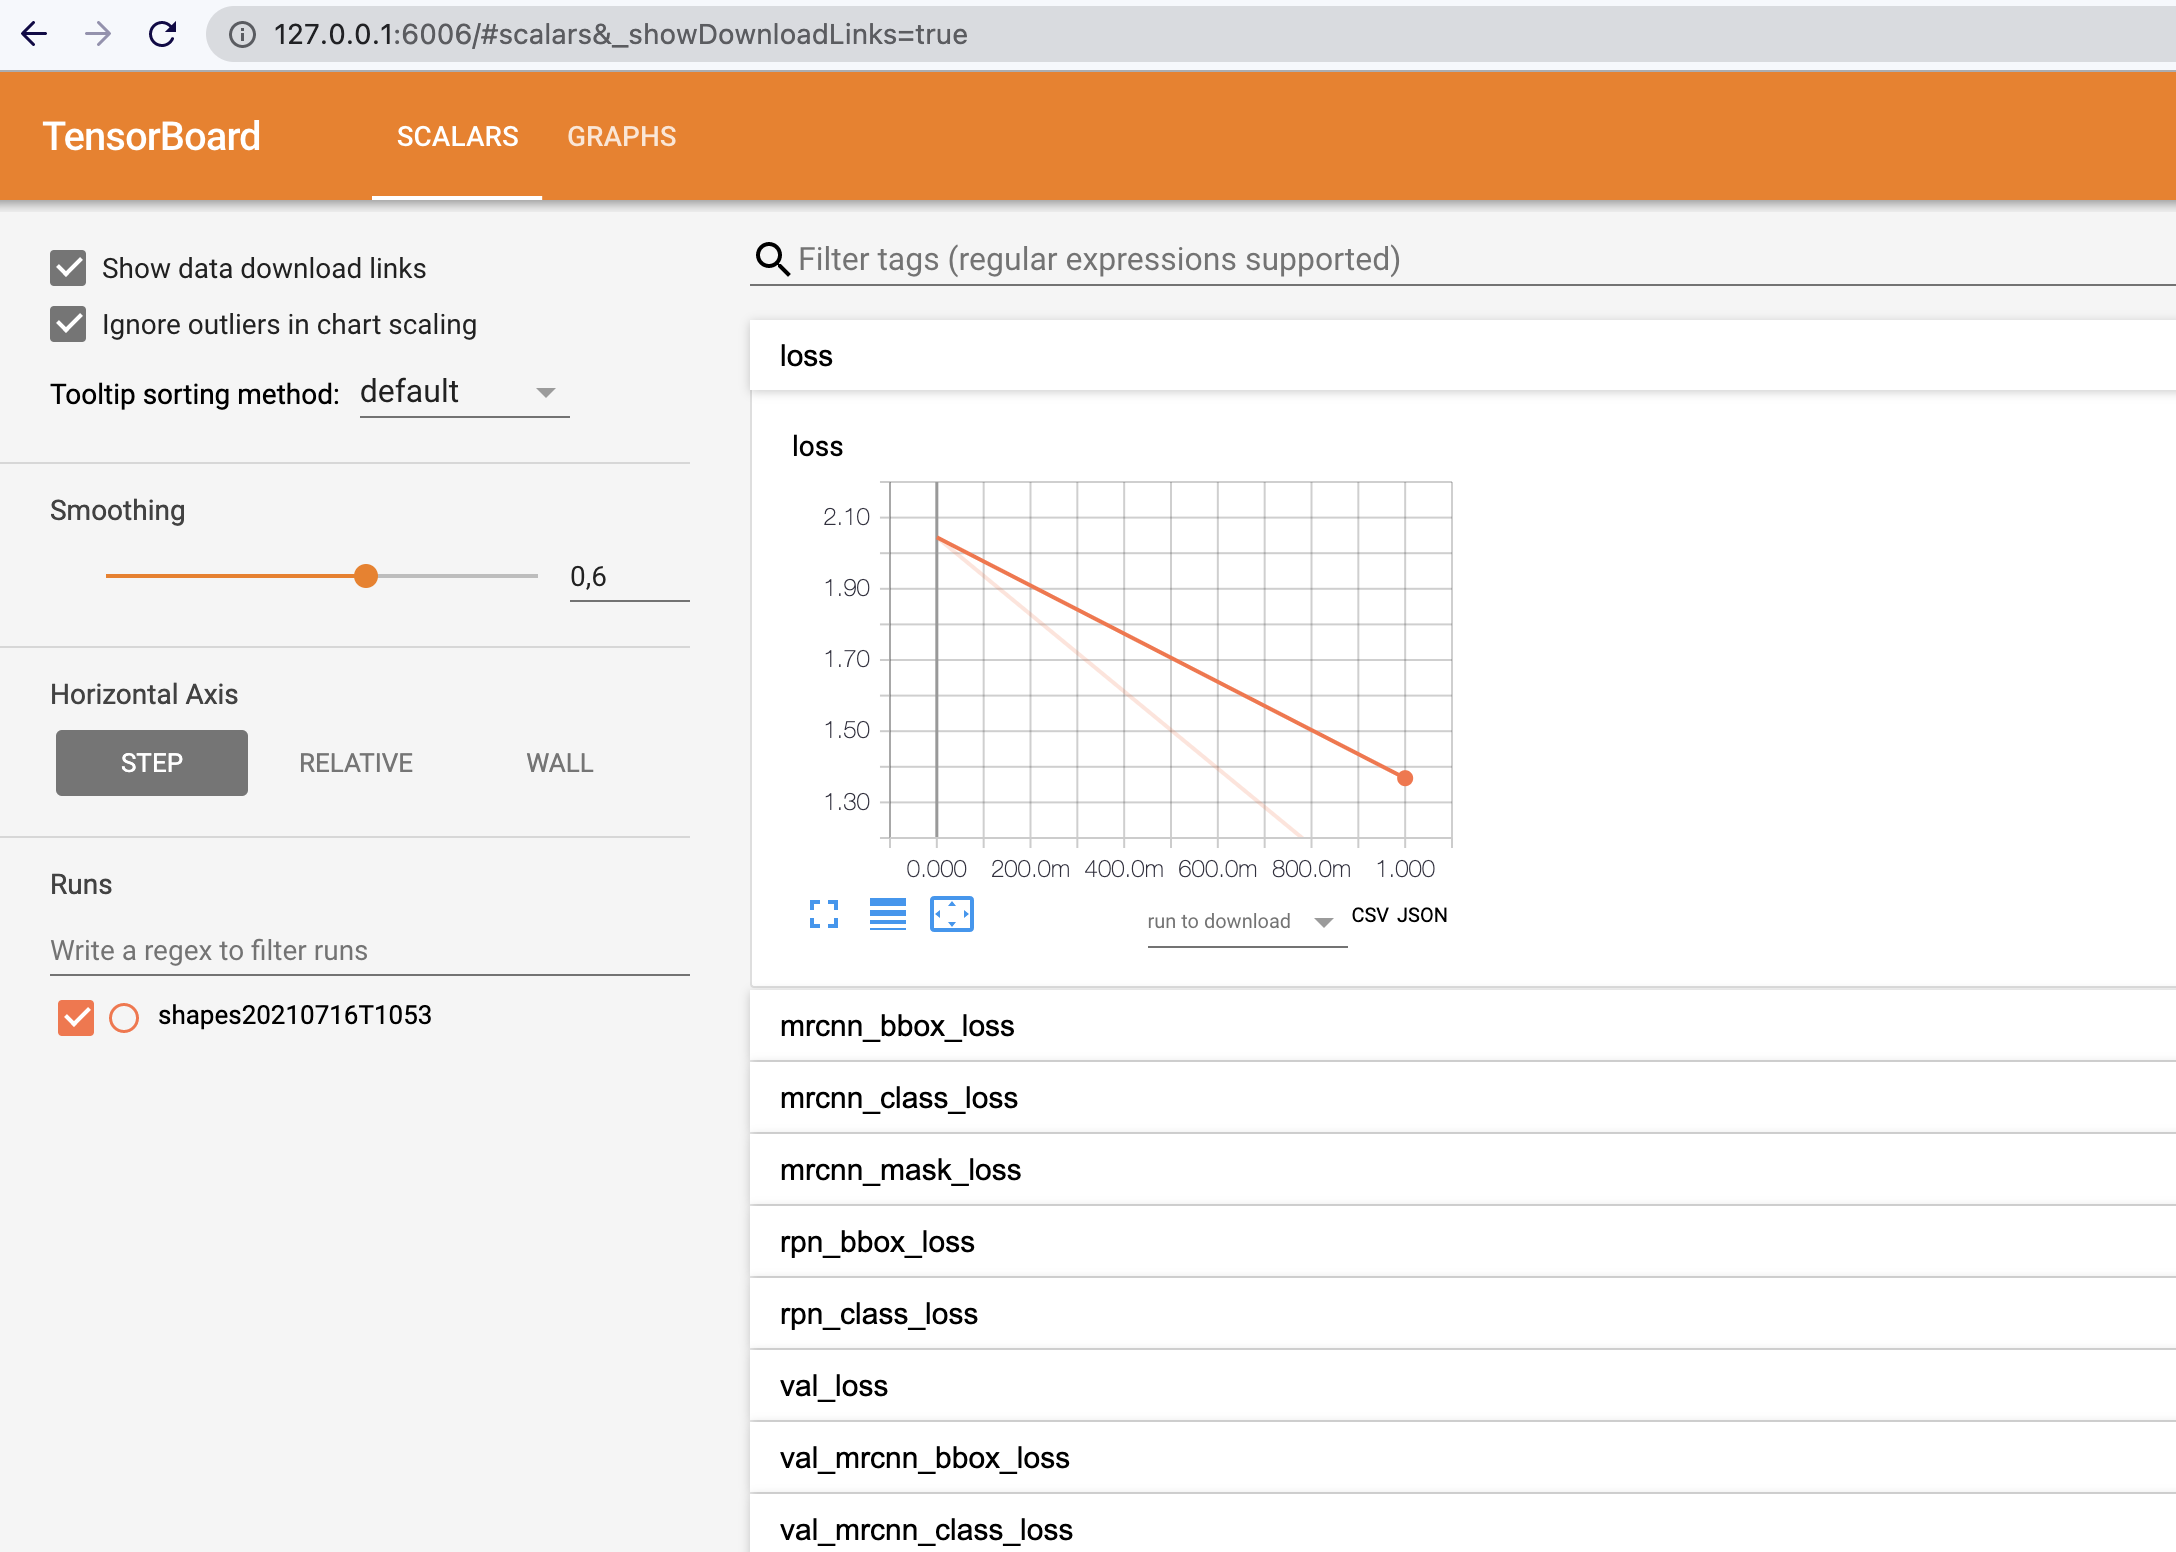

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/tmp"
Image(filename = PATH + "/tensorboard.png")

### 8.2. Реализация вывода параметров обучения в коде:

In [11]:
import numpy as np
import matplotlib.pyplot as mt
import tensorflow as tf
import _pickle as pickle
import os
import time
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

tf.__version__

print (tf.test.is_gpu_available)
#this function is useful in order to delete old graphs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='iso-8859-1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10_val(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(2,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)   
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    f = os.path.join(ROOT, 'data_batch_%d' % (1, ))
    X_val, Y_val = load_CIFAR_batch(f)
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte, X_val, Y_val


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



plt.rcParams['figure.figsize'] = (10.0, 8.0)


path = '/home/lmv/'
path = ''
cifar10_dir = path+ 'cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test, X_val, y_val = load_CIFAR10_val(cifar10_dir)

height = 32
width = 32
channels = 3
n_inputs = height*width*channels
num_features = height*width*channels

X_train_copy = X_train.copy()
X_train = np.zeros((X_train.shape[0], height, width, channels), dtype = np.float64)
X_train[:, :,:,0] = X_train_copy[:, 0,:,:]
X_train[:, :,:,1] = X_train_copy[:, 1,:,:]
X_train[:, :,:,2] = X_train_copy[:, 2,:,:]

X_test_copy = X_test.copy()
X_test = np.zeros((X_test.shape[0], height, width, channels), dtype = np.float64)
X_test[:, :,:,0] = X_test_copy[:, 0,:,:]
X_test[:, :,:,1] = X_test_copy[:, 1,:,:]
X_test[:, :,:,2] = X_test_copy[:, 2,:,:]

X_val_copy = X_val.copy()
X_val = np.zeros((X_val.shape[0], height, width, channels), dtype = np.float64)
X_val[:, :,:,0] = X_val_copy[:, 0,:,:]
X_val[:, :,:,1] = X_val_copy[:, 1,:,:]
X_val[:, :,:,2] = X_val_copy[:, 2,:,:]

X_train /= 255.
X_test /= 255.
X_val /= 255.


drp = 0.1

s = tf.InteractiveSession()

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name = "X")
y = tf.placeholder(tf.int32, shape = [None], name = "y")
is_training = tf.placeholder_with_default(True, ())

conv01 = tf.layers.conv2d(X,      filters=32, kernel_size = (3,3), strides = 1, padding="SAME", activation= tf.nn.relu, name="conv1")
conv02 = tf.layers.conv2d(conv01, filters=32, kernel_size = (3,3), strides = 1, padding="SAME", activation= tf.nn.relu, name="conv2")
pool03 = tf.layers.max_pooling2d(conv02, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop03 = tf.layers.dropout( pool03,  rate=drp)

conv04 = tf.layers.conv2d(drop03, filters=128, kernel_size = (3,3), strides = 1, padding="SAME", activation = tf.nn.relu, name="conv3")
conv05 = tf.layers.conv2d(conv04, filters=128, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv4")
pool06 = tf.layers.max_pooling2d(conv05, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop06 = tf.layers.dropout( pool06,  rate=drp)

conv07 = tf.layers.conv2d(drop06, filters=256, kernel_size = (3,3), strides= 1, padding="SAME", activation = tf.nn.relu, name="conv5")
conv08 = tf.layers.conv2d(conv07, filters=256, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv6")
conv09 = tf.layers.conv2d(conv08, filters=256, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv7")
pool10 = tf.layers.max_pooling2d(conv09, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop10 = tf.layers.dropout( pool10,  rate=drp)

conv11 = tf.layers.conv2d(drop10, filters=512, kernel_size = (3,3), strides= 1, padding="SAME", activation = tf.nn.relu, name="conv8")
conv12 = tf.layers.conv2d(conv11, filters=512, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv9")
conv13 = tf.layers.conv2d(conv12, filters=512, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv10")
pool14 = tf.layers.max_pooling2d(conv13, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop14 = tf.layers.dropout( pool14,  rate=drp)

pool2_flat = tf.reshape(drop14, shape=[-1,512*2*2])
fc1 = tf.layers.dense(pool2_flat, 256, activation = tf.nn.relu, name = "fc1")

logits = tf.layers.dense(fc1, 10, name = "output")
#Y_proba = tf.nn.softmax(logits, name="Y_proba")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()


n_epochs = 30
batch_size = 256      
       
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            X_batch, y_batch = batch
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            X_batch, y_batch = batch
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})       
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch:",epoch+1, "Train accuracy:", acc_train,  "val accuracy:", acc_val, "test accuracy:", acc_test,'t=',time.time() - start_time) 

<function is_gpu_available at 0x7fab11c06f28>


/home/lmv/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1 Train accuracy: 0.375 val accuracy: 0.4139 test accuracy: 0.3992 t= 7.7460901737213135
Epoch: 2 Train accuracy: 0.58203125 val accuracy: 0.5866 test accuracy: 0.5637 t= 7.300997257232666
Epoch: 3 Train accuracy: 0.66015625 val accuracy: 0.632 test accuracy: 0.6108 t= 7.467984437942505
Epoch: 4 Train accuracy: 0.734375 val accuracy: 0.7326 test accuracy: 0.6833 t= 7.312005281448364
Epoch: 5 Train accuracy: 0.76953125 val accuracy: 0.7971 test accuracy: 0.7207 t= 7.33941912651062
Epoch: 6 Train accuracy: 0.8125 val accuracy: 0.7799 test accuracy: 0.7076 t= 7.324307203292847
Epoch: 7 Train accuracy: 0.85546875 val accuracy: 0.8287 test accuracy: 0.7385 t= 7.335966348648071
Epoch: 8 Train accuracy: 0.84375 val accuracy: 0.8531 test accuracy: 0.7463 t= 7.357618808746338
Epoch: 9 Train accuracy: 0.89453125 val accuracy: 0.8708 test accuracy: 0.7519 t= 7.333460330963135
Epoch: 10 Train accuracy: 0.91015625 val accuracy: 0.8697 test accuracy: 0.7472 t= 7.344472408294678
Epoch: 11 Trai

### 8.3. Реализация с аугментацией:

In [ ]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as mt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import _pickle as pickle
import os
import time
import matplotlib.pyplot as plt
import seaborn

%cd /Volumes/Storage/ML_Sberbank

from myfunctions import *


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='iso-8859-1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10_val(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(2,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    f = os.path.join(ROOT, 'data_batch_%d' % (1, ))
    X_val, Y_val = load_CIFAR_batch(f)
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte, X_val, Y_val


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    Xi = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(Xi, (IMAGE_SIZE, IMAGE_SIZE), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())        
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = session.run(tf_img, feed_dict = {Xi: img})
            X_data.append(resized_img)
    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

# Produce each image at scaling of 90%, 75% and 60% of original image.
def central_scale_images(X_imgs, scales):
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)    
    X_scale_data = []
    tf.reset_default_graph()
    Xi = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(Xi, boxes, box_ind, crop_size)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())       
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = session.run(tf_img, feed_dict = {Xi: batch_img})
            X_scale_data.extend(scaled_imgs)
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data

#

# Produce each image at scaling of 90%, 75% and 60% of original image.
#scaled_imgs = central_scale_images(X_imgs, [0.90, 0.75, 0.60])


from math import ceil, floor

def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
    return offset, size, w_start, w_end, h_start, h_end

#X_imgs = X_train.copy()
#scales = [0.90, 0.75, 0.60]
#y = y_train

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
# !
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = session.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
			 w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr
	
#translated_imgs = translate_images(X_imgs)


def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    Xi = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(Xi, k = k)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = session.run(tf_img, feed_dict = {Xi: img, k: i + 1})
                X_rotate.append(rotated_img)        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate



from math import pi

def rotate_images_3(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * pi / 180  # Convert to radian
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate	
# Start rotation at -90 degrees, end at 90 degrees and produce totally 14 images
#rotate_images_3 = rotate_images(X_imgs, -90, 90, 14)


def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip
	
#flipped_images = flip_images(X_imgs)


def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1
        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy
  
#salt_pepper_noise_imgs = add_salt_pepper_noise(X_imgs)

# conda install -c conda-forge opencv 
#import cv2

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs
  
#gaussian_noise_imgs = add_gaussian_noise(X_imgs)


def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix, (X_img.shape[1], X_img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped_img
  


plt.rcParams['figure.figsize'] = (10.0, 8.0) 


path = '/home/lmv/'
cifar10_dir = path+ 'cifar10/cifar-10-batches-py'

path = '/Users/noname'
cifar10_dir = path+ 'cifar10/cifar-10-batches-py'

cifar10_dir = '/Users/noname/cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test, X_val, y_val = load_CIFAR10_val(cifar10_dir)

height = 32
width = 32
channels = 3
num_features = height*width*channels

X_train_copy = X_train.copy()
X_train = np.zeros((X_train.shape[0], height, width, channels), dtype = np.float64)
X_train[:, :,:,0] = X_train_copy[:, 0,:,:]
X_train[:, :,:,1] = X_train_copy[:, 1,:,:]
X_train[:, :,:,2] = X_train_copy[:, 2,:,:]

X_test_copy = X_test.copy()
X_test = np.zeros((X_test.shape[0], height, width, channels), dtype = np.float64)
X_test[:, :,:,0] = X_test_copy[:, 0,:,:]
X_test[:, :,:,1] = X_test_copy[:, 1,:,:]
X_test[:, :,:,2] = X_test_copy[:, 2,:,:]

X_val_copy = X_val.copy()
X_val = np.zeros((X_val.shape[0], height, width, channels), dtype = np.float64)
X_val[:, :,:,0] = X_val_copy[:, 0,:,:]
X_val[:, :,:,1] = X_val_copy[:, 1,:,:]
X_val[:, :,:,2] = X_val_copy[:, 2,:,:]


#VGG_MEAN = [103.939, 116.779, 123.68]

X_train /= 255.
X_test /= 255.
X_val /= 255.

del X_train_copy, X_test_copy, X_val_copy

print(X_train.shape, y_train.shape)


IMAGE_SIZE = 32

# сортировать картинки разного класса 00000 111111 22222 3333

counter = got_counter(y_train)
res_df = pd.DataFrame.from_dict(counter, orient='index').reset_index().rename(columns={'index':'event', 0:'count'})
res_df = res_df.sort_values(by=['count'], ascending=False).reset_index(drop=True)
level = [x for x in res_df['count']]
N = 500; #np.min(level)
level = [x for x in res_df[res_df['count'] > N]['event']]
numml = [x for x in res_df[res_df['count'] > N]['count']]

X_train_cat = []
y_train_cat = []
for i in range(len(level)):
    M = N/numml[i]
    db = X_train[y_train == level[i]].copy()
    X1, X2  = train_test_split(db, train_size = M, random_state = 17)
    X_train_cat.extend(X1)
    y_train_cat.extend([level[i] for x in range(N)])
X_train_cat = np.array(X_train_cat, dtype = np.float32)
y_train_cat = np.array(y_train_cat, dtype = np.int)

print(X_train_cat.shape, y_train_cat.shape)

    
# сортировать картинки разного класса:  0 1 2 3 4 5 6 7 8 9
X_train_cat2 = np.zeros((len(X_train_cat), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
y_train_cat2 = np.zeros((len(X_train_cat), ), dtype = np.int)
for j in range(10):
    db = X_train_cat[y_train_cat == j].copy()
    for i in range(N):
        X_train_cat2[j+i*10, :,:,:] = db[i, :,:,:]
        y_train_cat2[j+i*10,] = j   

X_train_cat2 = np.array(X_train_cat2, dtype = np.float32)
y_train_cat2 = np.array(y_train_cat2, dtype = np.int)

print(X_train_cat2.shape, y_train_cat2.shape)

#X_train = X_train_cat.copy() # плохо
#y_train = y_train_cat.copy()
X_train = X_train_cat2.copy()
y_train = y_train_cat2.copy()

del X_train_cat, X_train_cat2, y_train_cat, y_train_cat2, X1, X2, db

#X_train = X_train[:1000, :,:,:].copy()
#y_train = y_train[:1000]




X_train_scaled_imgs = central_scale_images(X_train, [0.75, 0.60])
y_train_scaled_imgs = []
for x in y_train:
    for k in range(len([0.75, 0.60])):
        y_train_scaled_imgs.append(x)
    
X_train_rotate_images = rotate_images(X_train)
y_train_rotate_images = np.concatenate([y_train, y_train, y_train], axis = 0)

X_train_translate_images = translate_images(X_train)
y_train_translate_images = np.concatenate([y_train, y_train, y_train, y_train], axis = 0)

X_train_flipped_images = flip_images(X_train)
y_train_flipped_images = np.concatenate([y_train, y_train, y_train], axis = 0)

X_train_salt_pepper_noise_imgs = add_salt_pepper_noise(X_train)
y_train_salt_pepper_noise_imgs = y_train

#X_train_rotate_images_3 = rotate_images_3(X_train, -90, 90, 14)

X_train = np.concatenate([X_train, X_train_scaled_imgs, X_train_rotate_images, X_train_translate_images, X_train_flipped_images, X_train_salt_pepper_noise_imgs], axis = 0)
y_train = np.concatenate([y_train, y_train_scaled_imgs, y_train_rotate_images, y_train_translate_images, y_train_flipped_images, y_train_salt_pepper_noise_imgs], axis = 0)

del X_train_scaled_imgs, X_train_rotate_images, X_train_translate_images, X_train_flipped_images, X_train_salt_pepper_noise_imgs
del y_train_scaled_imgs, y_train_rotate_images, y_train_translate_images, y_train_flipped_images, y_train_salt_pepper_noise_imgs


print(X_train.shape, y_train.shape)


######################################################################################################
drp = 0.25

reset_graph()
X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name = "X")
y = tf.placeholder(tf.int32, shape = [None], name = "y")
is_training = tf.placeholder_with_default(True, ())

conv01 = tf.layers.conv2d(X,      filters=32, kernel_size = (3,3), strides = 1, padding="SAME", activation= tf.nn.relu, name="conv1")
conv02 = tf.layers.conv2d(conv01, filters=32, kernel_size = (3,3), strides = 1, padding="SAME", activation= tf.nn.relu, name="conv2")
pool03 = tf.layers.max_pooling2d(conv02, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop03 = tf.layers.dropout( pool03,  rate=drp, training=is_training)

conv04 = tf.layers.conv2d(drop03, filters=128, kernel_size = (3,3), strides = 1, padding="SAME", activation = tf.nn.relu, name="conv3")
conv05 = tf.layers.conv2d(conv04, filters=128, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv4")
pool06 = tf.layers.max_pooling2d(conv05, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop06 = tf.layers.dropout( pool06,  rate=drp, training=is_training)

conv07 = tf.layers.conv2d(drop06, filters=256, kernel_size = (3,3), strides= 1, padding="SAME", activation = tf.nn.relu, name="conv5")
conv08 = tf.layers.conv2d(conv07, filters=256, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv6")
conv09 = tf.layers.conv2d(conv08, filters=256, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv7")
pool10 = tf.layers.max_pooling2d(conv09, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop10 = tf.layers.dropout( pool10,  rate=drp, training=is_training)

conv11 = tf.layers.conv2d(drop10, filters=512, kernel_size = (3,3), strides= 1, padding="SAME", activation = tf.nn.relu, name="conv8")
conv12 = tf.layers.conv2d(conv11, filters=512, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv9")
conv13 = tf.layers.conv2d(conv12, filters=512, kernel_size = (3,3), strides= 1, padding="SAME", activation=tf.nn.relu, name="conv10")
pool14 = tf.layers.max_pooling2d(conv13, pool_size=(2, 2), strides=(2,2), padding="VALID")
drop14 = tf.layers.dropout( pool14,  rate=0.25, training=is_training)

pool2_flat = tf.reshape(drop14, shape=[-1,512*2*2])
fc1 = tf.layers.dense(pool2_flat, 256, activation = tf.nn.relu, name = "fc1")

logits = tf.layers.dense(fc1, 10, name = "output")
#Y_proba = tf.nn.softmax(logits, name="Y_proba")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
#init = tf.global_variables_initializer()


####################################################################################

n_epochs = 20
batch_size = 100    

sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.global_variables_initializer().run()
for epoch in range(n_epochs):
    start_time = time.time()
    acc_tr = 0
    batches = 0
    for batch in tqdm(iterate_minibatches(X_train, y_train, batch_size)):
        X_batch, y_batch = batch
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch, is_training: True})
#        acc_tr += accuracy.eval(feed_dict={X: X_batch, y: y_batch})
#        batches += 1
#    acc_tr_mean = acc_tr / batches
    acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, is_training: False })
#    for batch in iterate_minibatches(X_val, y_val, batch_size):
#        X_batch, y_batch = batch
#        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, is_training: False })        
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, is_training: False })
    print("Epoch:",epoch+1, "Train accuracy:", acc_train, "val accuracy:", acc_val, "test accuracy:", acc_test,'time',time.time() - start_time) 
sess.close()


### is_training - ставить false если нужен подсчет точности без обучения сети
### learning rate настраивать уменьшение шага с каждой эпохой (?)

"""
Epoch: 1 Train accuracy: 0.69 val accuracy: 0.6943 test accuracy: 0.6958 time 90.99169993400574
Epoch: 2 Train accuracy: 0.8 val accuracy: 0.7722 test accuracy: 0.7718 time 91.37837386131287
Epoch: 3 Train accuracy: 0.89 val accuracy: 0.7997 test accuracy: 0.7965 time 91.19675898551941
Epoch: 4 Train accuracy: 0.88 val accuracy: 0.8104 test accuracy: 0.803 time 91.24759650230408
Epoch: 5 Train accuracy: 0.95 val accuracy: 0.8178 test accuracy: 0.8117 time 91.19879269599915
Epoch: 6 Train accuracy: 0.9 val accuracy: 0.8157 test accuracy: 0.8094 time 91.25263142585754
Epoch: 7 Train accuracy: 0.93 val accuracy: 0.8186 test accuracy: 0.8118 time 91.21569657325745
Epoch: 8 Train accuracy: 0.95 val accuracy: 0.8231 test accuracy: 0.8194 time 91.14586281776428
Epoch: 9 Train accuracy: 0.96 val accuracy: 0.8386 test accuracy: 0.8342 time 91.02920436859131
Epoch: 10 Train accuracy: 0.95 val accuracy: 0.8236 test accuracy: 0.8293 time 91.09612393379211
Epoch: 11 Train accuracy: 0.97 val accuracy: 0.8343 test accuracy: 0.828 time 91.00448441505432
Epoch: 12 Train accuracy: 0.94 val accuracy: 0.8235 test accuracy: 0.8202 time 90.98033261299133
Epoch: 13 Train accuracy: 0.95 val accuracy: 0.8388 test accuracy: 0.8313 time 90.97825574874878
Epoch: 14 Train accuracy: 0.95 val accuracy: 0.8352 test accuracy: 0.8317 time 90.99379324913025
Epoch: 15 Train accuracy: 0.97 val accuracy: 0.842 test accuracy: 0.8349 time 91.0456473827362
Epoch: 16 Train accuracy: 0.95 val accuracy: 0.8348 test accuracy: 0.826 time 91.00385046005249
Epoch: 17 Train accuracy: 0.98 val accuracy: 0.8421 test accuracy: 0.8395 time 91.01088953018188
"""

c = X_train[0, :,:,:]

sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(c1 = conv01(c))
sess.close()


acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})

test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    _, acc = eval_fn(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: mage 80 lvl")
else:
    print("Feed more!")

 <div style="text-align: right"> <a href='#link_0'>Содержание</a> </div> 

### P.S.

In [28]:
!pip freeze > python.txt

In [29]:
!cat python.txt

absl-py==0.4.1
alabaster==0.7.12
annoy==1.12.0
args==0.1.0
astor==0.7.1
atari-py==0.1.1
Babel==2.9.1
backcall==0.1.0
bleach==1.5.0
Box2D-kengz==2.3.3
cachetools==2.1.0
certifi==2018.8.13
chardet==3.0.4
click==6.7
clint==0.5.1
cloudpickle==0.5.3
cycler==0.10.0
cymem==1.31.2
Cython==0.29.24
cytoolz==0.9.0.1
dask==0.18.2
decorator==4.3.0
dill==0.2.8.2
dlib==19.15.0
docutils==0.17.1
entrypoints==0.2.3
Flask==1.0.2
floyd-cli==0.11.7
ftfy==4.4.3
future==0.16.0
gast==0.2.0
grpcio==1.14.2
gym==0.10.5
gym-retro==0.5.6
h5py==2.8.0
html5lib==0.9999999
idna==2.7
ijson==2.3
imageio==2.9.0
imagesize==1.2.0
imgaug==0.4.0
incremental==17.5.0
ipykernel==4.8.2
ipyparallel==6.3.0
ipython==6.5.0
ipython-genutils==0.2.0
ipywidgets==7.4.0
itsdangerous==0.24
jedi==0.12.1
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
jupyterlab==0.33.8
jupyterlab-launcher==0.11.2
kaggle==1.4.6
Keras==2.0.8
Keras-Applications==1.0.2
Keras-Preprocessing==1.0.1
kiw